In [ ]:
# default_exp loss
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# Loss

> Train and evaluate your algorithms on real data. You can also save the model for later use, or deploy it to production!



***input:*** clean and tidy dataset from data notebook + ML model class from hypotheses space notebook

***output:*** evaluated, trained and (optionally) deployed model

***description:***

In this notebook you train and evaluate ML methods implemented with the whole dataset.
You can also save the model for later use, or deploy it to production environment, or use this notebook as the final output.

## Import relevant modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu
from sklearn.model_selection import train_test_split

# import ml class and plot functions defined in previous notebooks
from ml_project_template.model import LogisticRegressionClassifier
from ml_project_template.data import plot_trellis, plot_histogram

## Define notebook parameters

In [ ]:
# This cell is tagged with 'parameters'
seed = 0

make direct derivations from the parameters:

In [ ]:
np.random.seed(seed)

## Load the clean and tidy data produced in the data notebook

In [ ]:
df = pd.read_csv(
    "data/preprocessed_data/dataset_clean_switzerland_cleveland.csv", index_col=0
)

In [ ]:
df.head()

x1age  x4trestbps  x8thalach  x10oldpeak  y1num
0   57.0       120.0      163.0         0.6      0
1   63.0       108.0      169.0         1.8      1
2   47.0       160.0      124.0         0.0      1
3   63.0       100.0      109.0        -0.9      1
4   57.0       150.0      174.0         1.6      0

> Note that depending on the file format and your variables, you might have to refefine datatypes in your dataframe!

## Split the data into training, testing and validation data

The `LogisticRegressionClassifier` model splits data into training and testing data using k-fold cross validation.
We could also separate a validation dataset to test against overfitting model hyperparameters.
It could be done here, or by the model class instance.


In [ ]:
# separate validation data before giving data to the model
# (our example model will do the separation to training and testing data)
X_train_test, X_val, y_train_test, y_val = train_test_split(
    df.iloc[:, :-1], df.iloc[:, -1]
)

Train & test data size:

In [ ]:
X_train_test.shape

(315, 4)

Validation data size:

In [ ]:
X_val.shape

(105, 4)

## Define Loss function

You might want to define different evaluation metrics for testing and evaluation.

In our example we use the f1 score for both.

## Train and evaluate the models

In [ ]:
# create model with whole dataset
model = LogisticRegressionClassifier(X_train_test, y_train_test)
# optimize model (here optimization function fits the model with best hyperparameters)
model.optimize()
print(f"train_loss: {model.get_train_loss()}")
print(f"test_loss: {model.get_test_loss()}")

train_loss: 0.7491638795986622
test_loss: 0.8205128205128206


f1 score of around 0.8 is an ok result, but of course  could be improved. We leave that for you as an exercise!

## Visualize results

There are tons of things you could visualize with machine learning.

Assuming we wanted to improve our model, we would be especially interested in knowing where it fails.
Let's visualize the test data with the trellis plot function defined in data notebook.
However, here we do not select the glyph based on the true label, but rather the prediction correctness.

This may help us discover patterns.
Assuming our model was doing as good job with the data as possible, the incorrect predictions should follow the same pattern as the correct ones.

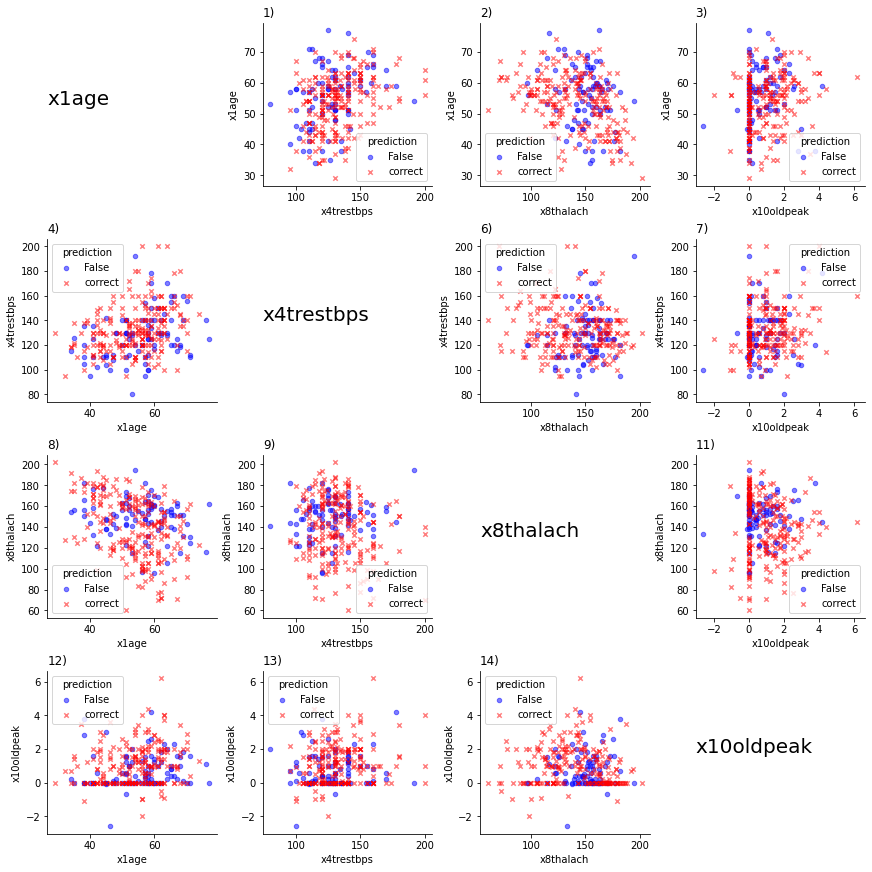

In [ ]:
train_test_df = X_train_test.copy()
train_test_df["prediction_correct"] = (
    model.predict(X_train_test) - y_train_test.values == 0
)
_ = plot_trellis(train_test_df, legend_title="prediction", true_label="correct")

Ok, ito me it appears that with regard to the talach feature the false predictions are not spread as wide as the correct predictions.
This is, however hard to see with naked eye.

Luckily we we can include statistical tests.
Here we test the equality of the spatial distributions of the false and correct predictions.

In [ ]:
def test_equality_paired(sample1, sample2, a=0.05):
    """
    Test equality of distributions of paired samples with wilcoxon signed rank test
    """
    reject = lambda p: True if p < a else False
    print("Null hypothesis: samples come from identical distibution")
    stat, p = wilcoxon(sample1, sample2)  # for paired samples
    print(
        f"Willcoxon statistic: {stat}\tp-value: {p}\nnull hypothesis rejected: {reject(p)}"
    )
    print("\n")


def test_equality(sample1, sample2, a=0.05):
    """
    Test equatily of distributions of non-paired samples with mann-whitney u-test
    """
    reject = lambda p: True if p < a else False
    print("Null hypothesis: samples come from identical distibution")
    stat, p = mannwhitneyu(sample1, sample2)  # for non-paired samples
    print(
        f"Mann-whitney U statistic: {stat}\tp-value: {p}\nnull hypothesis rejected: {reject(p)}"
    )
    print("\n")

Test equality of distributions for the label and predicted label with test data:

In [ ]:
test_equality_paired(y_train_test, model.predict(X_train_test))

Null hypothesis: samples come from identical distibution
Willcoxon statistic: 1845.0	p-value: 0.45808823471581006
null hypothesis rejected: False




Ok, so predictions contain label values in same proportions as in the true data. 

Next, test equality of distributions between correct and incorrect predictions:

In [ ]:
for i in range(train_test_df.shape[1] - 1):
    print(f"Feature: {train_test_df.columns[i]}")
    print("samples: true and false predictions")
    sample1 = train_test_df[train_test_df.prediction_correct == 1].iloc[:, i]
    sample2 = train_test_df[train_test_df.prediction_correct == 0].iloc[:, i]
    test_equality(sample1, sample2)

Feature: x1age
samples: true and false predictions
Null hypothesis: samples come from identical distibution
Mann-whitney U statistic: 8944.5	p-value: 0.06313580734293253
null hypothesis rejected: False


Feature: x4trestbps
samples: true and false predictions
Null hypothesis: samples come from identical distibution
Mann-whitney U statistic: 8545.0	p-value: 0.018687867416379563
null hypothesis rejected: True


Feature: x8thalach
samples: true and false predictions
Null hypothesis: samples come from identical distibution
Mann-whitney U statistic: 8257.5	p-value: 0.006714370755259867
null hypothesis rejected: True


Feature: x10oldpeak
samples: true and false predictions
Null hypothesis: samples come from identical distibution
Mann-whitney U statistic: 8919.0	p-value: 0.05562603073429994
null hypothesis rejected: False




Ok, so the false and correct predictions are infact differently distributed with regard to the trestbps and talach features. Interesting!
We could use this information to improve our model.

## Validate best model (if hyperparameters are optimized)

In [ ]:
model.loss(X_val, y_val)

0.7874015748031497

## Visualize validation

In [ ]:
# collect loss values to a table for easier visualization
eval_df = pd.DataFrame(
    {
        "train_loss": [model.get_train_loss()],
        "test_loss": [model.get_test_loss()],
        "val_loss": [model.loss(X_val, y_val)],
    }
).T
eval_df

0
train_loss  0.749164
test_loss   0.820513
val_loss    0.787402

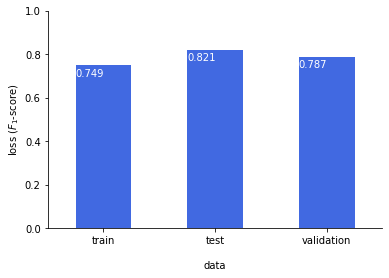

In [ ]:
fig, ax = plt.subplots(1)

# plot settings
barcolor = "royalblue"
barwidth = 0.5

eval_df.plot(ax=ax, kind="bar", width=barwidth, color=barcolor)
ax.set_ylim(ymax=1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.get_legend().remove()

# offsets and colours for annotation:
text_offset = 0.05
upper_lower = lambda x: x - text_offset if x > 0.5 else x + text_offset
black_white = lambda x: "white" if x > 0.5 else barcolor
# annotate:
for i in range(eval_df.shape[0]):
    val = round(eval_df.iloc[i].values[0], 3)
    ax.annotate(
        text=f"{val}",
        xy=(i - barwidth / 2, upper_lower(val)),
        color=black_white(val),
    )
# rename axis
ax.set_ylabel("loss ($F_1$-score)")
ax.set_xlabel("\ndata")
ax.set_xticklabels(["train", "test", "validation"], rotation=0)
plt.show()

## Conclusions

Explain the model behaviour results to your best understanding.

Compare to benchmark results, if available.

From [benchmarking results](https://www.researchgate.net/figure/Comparison-of-Classification-Techniques-for-Heart-Disease-Prediction_tbl2_328031918)
we can see that our F1 score of 0.8 should be pretty ok result,
although the benchmarking results were evaluated on accuracy, not f1 score so we can not exactly compare these two measures together.
If you want, you can edit the model to use accuracy as the evaluation metric as an excercise for using this template.

## Save or deploy trained model

Congratulations, you now have a trained and evaluated ML model ready for action!
It is time to save it for later use or deploy it in production environment directly.

In your work you might want to simply begin by saving the trained model as a pickle and consider the workflow notebook before returning to deployment.
It can reveal reveal and help you solve issues with the reproducibility and automation of your workflow.

There are five common ways for doing this:

1. Pickle the model. This means saving it in a pickle format,
that can be loaded in any Python environment with the same python version and equal dependencies installed.
The dependencies are defined in `requirements.txt`. 
2. Extract model parameters. Alternatively, you can save the model parameters in a config file,
that allows you to reconstruct the model in your target environment.
This allows you to even reconstruct the model in a different programming language, if you wish.
3. Create an API. You can create an executable Python application with API to make new predictions.
The workflow notebook contains a pseudo example of an API to our example ML model.
4. Embed model inside a web application using Flask, Django or Dash, and use your model as a containerized microservice.
5. Deploy the model to a cloud service, for example as an Azure Functions application or Azure Machine Learning model.

In addition you might want to share the code you created so it can be applied to different problems.
See the instructions in [nbdev docs](https://nbdev.fast.ai/tutorial.html#Upload-to-pypi) on how to publish PyPI package created with nbdev.
You can also create github hosted documentation pages for your project with `nbdev_build_docs`.
Nbdev will convert your notebooks to HTML pages for you with links to your github repo.

These options are not exclusive. You might want to perform multiple of them in your project.


The pickling option is the most simple one, so we demonstrate it here:

In [ ]:
import pickle

filename = "results/LogisticRegressionClassifier.pkl" # name of the file containing trained model
with open(filename, "wb") as f:
    pickle.dump(model, f) # trained model is saved as-is

You can now load the pickled trained model in another environment:
```
with open(filename, "rb") as f:
    model = pickle.load(f)
```

We can also test if the model was saved successfully:

In [ ]:
# test model load
def test_pickle_load():
    with open(filename, "rb") as f:
        return pickle.load(f).get_train_loss() == model.get_train_loss()


assert test_pickle_load()

## You can now move on to the workflow notebook!